# Temporal Aggregation (Tourism)

> Temporal Hierarchical Forecasting on Australian Tourism Data

In many applications, a set of time series is hierarchically organized. Examples include the presence of geographic levels, products, or categories that define different types of aggregations. In such scenarios, forecasters are often required to provide predictions for all disaggregate and aggregate series. A natural desire is for those predictions to be **"coherent"**, that is, for the bottom series to add up precisely to the forecasts of the aggregated series.

In this notebook we present an example on how to use `HierarchicalForecast` to produce coherent forecasts between  temporal levels. We will use the classic Australian Domestic Tourism (`Tourism`) dataset, which contains monthly time series of the number of visitors to each state of Australia.

We will first load the `Tourism` data and produce base forecasts using an `AutoETS` model from `StatsForecast`. Then, we reconciliate the forecasts with several reconciliation algorithms from `HierarchicalForecast` according to a temporal hierarchy.

You can run these experiments using CPU or GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/AustralianDomesticTourismCrossTemporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install hierarchicalforecast statsforecast

## 1. Load and Process Data

In this example we will use the [Tourism](https://otexts.com/fpp3/tourism.html) dataset from the [Forecasting: Principles and Practice](https://otexts.com/fpp3/) book.

The dataset only contains the time series at the lowest level, so we need to create the time series for all hierarchies.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
Y_df.insert(0, 'Country', 'Australia')
Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
Y_df['ds'] = pd.PeriodIndex(Y_df["ds"], freq='Q').to_timestamp()
Y_df.head()

,Country,Region,State,Purpose,ds,y
0,Australia,Adelaide,South Australia,Business,1998-01-01,135.077690
1,Australia,Adelaide,South Australia,Business,1998-04-01,109.987316
2,Australia,Adelaide,South Australia,Business,1998-07-01,166.034687
3,Australia,Adelaide,South Australia,Business,1998-10-01,127.160464
4,Australia,Adelaide,South Australia,Business,1999-01-01,137.448533


## 2. Temporal reconciliation

First, we add a `unique_id` to the data.

In [ ]:
Y_df["unique_id"] = Y_df["Country"] + "/" + Y_df["State"] + "/" + Y_df["Region"] + "/" + Y_df["Purpose"]

### 2a. Split Train/Test sets

We use the final two years (8 quarters) as test set. Consequently, our forecast horizon=8.

In [ ]:
horizon = 8

In [ ]:
Y_test_df = Y_df.groupby("unique_id", as_index=False).tail(horizon)
Y_train_df = Y_df.drop(Y_test_df.index)

### 2a. Aggregating the dataset according to temporal hierarchy

We first define the temporal aggregation spec. You can use string aliases of timestamp attributes to compute temporal aggregations. For Pandas, see an overview of allowable attributes [here](https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.html). 

In this example, we choose a temporal aggregation of `["year"]` and the bottom level `["year", "ds"]`. The bottom level timesteps have a quarterly frequency.

In [ ]:
spec_temporal = [
    ["year"],
    ["year", "ds"],
]   

We next compute the temporally aggregated train- and test sets using the `aggregate_temporal` function. Note that we have different aggregation matrices `S` for the train- and test set, as the test set contains temporal hierarchies that are not included in the train set.

In [ ]:
from hierarchicalforecast.utils import aggregate_temporal

In [ ]:
Y_train_df_te, S_train_df_te, tags_te_train = aggregate_temporal(df=Y_train_df, freq="QS", spec=spec_temporal)
Y_test_df_te, S_test_df_te, tags_te_test = aggregate_temporal(df=Y_test_df, freq="QS", spec=spec_temporal)


In [ ]:
Y_train_df_te

,temporal_id,unique_id,y,ds
0,1998,Australia/ACT/Canberra/Business,481.394885,1998-01-01
1,1998,Australia/ACT/Canberra/Holiday,604.140999,1998-01-01
2,1998,Australia/ACT/Canberra/Other,94.557381,1998-01-01
3,1998,Australia/ACT/Canberra/Visiting,672.761735,1998-01-01
4,1998,Australia/New South Wales/Blue Mountains/Business,59.195531,1998-01-01
...,...,...,...,...
27355,2015/2015-10-01,Australia/Western Australia/Australia's South ...,223.346491,2015-10-01
27356,2015/2015-10-01,Australia/Western Australia/Experience Perth/B...,267.437376,2015-10-01
27357,2015/2015-10-01,Australia/Western Australia/Experience Perth/H...,300.297583,2015-10-01
27358,2015/2015-10-01,Australia/Western Australia/Experience Perth/O...,109.968477,2015-10-01


Our aggregation matrices aggregate the lowest temporal granularity (quarters) up to years.

In [ ]:
S_train_df_te.iloc[:5, :5]

,temporal_id,1998/1998-01-01,1998/1998-04-01,1998/1998-07-01,1998/1998-10-01
0,1998,1.0,1.0,1.0,1.0
1,1999,0.0,0.0,0.0,0.0
2,2000,0.0,0.0,0.0,0.0
3,2001,0.0,0.0,0.0,0.0
4,2002,0.0,0.0,0.0,0.0


In [ ]:
S_test_df_te.iloc[:5, :5]

,temporal_id,2016/2016-01-01,2016/2016-04-01,2016/2016-07-01,2016/2016-10-01
0,2016,1.0,1.0,1.0,1.0
1,2017,0.0,0.0,0.0,0.0
2,2016/2016-01-01,1.0,0.0,0.0,0.0
3,2016/2016-04-01,0.0,1.0,0.0,0.0
4,2016/2016-07-01,0.0,0.0,1.0,0.0


If you don't have a test set available, as is usually the case when you're making forecasts, it is necessary to create a future dataframe that holds the correct bottom-level unique_ids and timestamps so that they can be temporally aggregated. We can use the `make_future_dataframe` helper function for that.

In [ ]:
from hierarchicalforecast.utils import make_future_dataframe

In [ ]:
Y_test_df_te_new = make_future_dataframe(Y_train_df, freq="QS", h=horizon)

`Y_test_df_te_new` can be then used in `aggregate_temporal` to construct the temporally aggregated structures:

In [ ]:
Y_df_test_new, S_df_te_test_new, tags_te_test_new = aggregate_temporal(df=Y_test_df_te_new, freq="QS", spec=spec_temporal)

And we can verify that we have the same temporally aggregated test set, except that `Y_df_te_test_new` doesn't contain the ground truth values `y`.

In [ ]:
Y_test_df_te

,temporal_id,unique_id,y,ds
0,2016,Australia/ACT/Canberra/Business,754.139245,2016-01-01
1,2016,Australia/ACT/Canberra/Holiday,735.365896,2016-01-01
2,2016,Australia/ACT/Canberra/Other,175.239916,2016-01-01
3,2016,Australia/ACT/Canberra/Visiting,792.656310,2016-01-01
4,2016,Australia/New South Wales/Blue Mountains/Business,73.981175,2016-01-01
...,...,...,...,...
3035,2017/2017-10-01,Australia/Western Australia/Australia's South ...,209.846009,2017-10-01
3036,2017/2017-10-01,Australia/Western Australia/Experience Perth/B...,270.986641,2017-10-01
3037,2017/2017-10-01,Australia/Western Australia/Experience Perth/H...,288.758614,2017-10-01
3038,2017/2017-10-01,Australia/Western Australia/Experience Perth/O...,87.494916,2017-10-01


In [ ]:
Y_df_test_new

,temporal_id,unique_id,ds
0,2016,Australia/ACT/Canberra/Business,2016-01-01
1,2016,Australia/ACT/Canberra/Holiday,2016-01-01
2,2016,Australia/ACT/Canberra/Other,2016-01-01
3,2016,Australia/ACT/Canberra/Visiting,2016-01-01
4,2016,Australia/New South Wales/Blue Mountains/Business,2016-01-01
...,...,...,...
3035,2017/2017-10-01,Australia/Western Australia/Australia's South ...,2017-10-01
3036,2017/2017-10-01,Australia/Western Australia/Experience Perth/B...,2017-10-01
3037,2017/2017-10-01,Australia/Western Australia/Experience Perth/H...,2017-10-01
3038,2017/2017-10-01,Australia/Western Australia/Experience Perth/O...,2017-10-01


### 3b. Computing base forecasts

Now, we need to compute base forecasts for each temporal aggregation. The following cell computes the **base forecasts** for each temporal aggregation in `Y_train_df_te` using the `AutoETS` model. Observe that `Y_hat_df_te` contains the forecasts but they are not coherent.

Note also that both frequency and horizon are different for each temporal aggregation. In this example, the lowest level has a quarterly frequency, and a horizon of `8` (constituting `2` years). The `year` aggregation thus has a yearly frequency with a horizon of `2`.

It is of course possible to choose a different model for each level in the temporal aggregation - you can be as creative as you like!

In [ ]:
from statsforecast.models import AutoETS
from statsforecast.core import StatsForecast

In [ ]:
Y_hat_dfs_te = []
id_cols = ["unique_id", "temporal_id", "ds", "y"]
# We will train a model for each temporal level
for level, temporal_ids_train in tags_te_train.items():
    # Filter the data for the level
    Y_level_train = Y_train_df_te.query("temporal_id in @temporal_ids_train")
    temporal_ids_test = tags_te_test[level]
    Y_level_test = Y_test_df_te.query("temporal_id in @temporal_ids_test")
    # For each temporal level we have a different frequency and forecast horizon
    freq_level = pd.infer_freq(Y_level_train["ds"].unique())
    horizon_level = Y_level_test["ds"].nunique()
    # Train a model and create forecasts
    fcst = StatsForecast(models=[AutoETS(model='ZZZ')], freq=freq_level, n_jobs=-1)
    Y_hat_df_te_level = fcst.forecast(df=Y_level_train[["ds", "unique_id", "y"]], h=horizon_level, level=[80, 90])
    # Add the test set to the forecast
    Y_hat_df_te_level = Y_hat_df_te_level.merge(Y_level_test, on=["ds", "unique_id"], how="left")
    # Put cols in the right order (for readability)
    Y_hat_cols = id_cols + [col for col in Y_hat_df_te_level.columns if col not in id_cols]
    Y_hat_df_te_level = Y_hat_df_te_level[Y_hat_cols]
    # Append the forecast to the list
    Y_hat_dfs_te.append(Y_hat_df_te_level)

Y_hat_df_te = pd.concat(Y_hat_dfs_te, ignore_index=True)


### 3c. Reconcile forecasts

We can use the `HierarchicalReconciliation` class to reconcile the forecasts. In this example we use `BottomUp` and `MinTrace`. Note that we have to set `temporal=True` in the `reconcile` function.

Note that temporal reconcilation currently isn't supported for insample reconciliation methods, such as `MinTrace(method='mint_shrink')`.

In [ ]:
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.core import HierarchicalReconciliation

In [ ]:
reconcilers = [
    BottomUp(),
    MinTrace(method='ols')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df_te = hrec.reconcile(Y_hat_df=Y_hat_df_te, S=S_test_df_te, tags=tags_te_test, temporal=True, level=[80, 90])

In [ ]:
Y_rec_df_te

,unique_id,temporal_id,ds,y,AutoETS,AutoETS-lo-90,AutoETS-lo-80,AutoETS-hi-80,AutoETS-hi-90,AutoETS/BottomUp,AutoETS/BottomUp-lo-90,AutoETS/BottomUp-lo-80,AutoETS/BottomUp-hi-80,AutoETS/BottomUp-hi-90,AutoETS/MinTrace_method-ols,AutoETS/MinTrace_method-ols-lo-90,AutoETS/MinTrace_method-ols-lo-80,AutoETS/MinTrace_method-ols-hi-80,AutoETS/MinTrace_method-ols-hi-90
0,Australia/ACT/Canberra/Business,2016,2016-01-01,754.139245,616.497987,474.588329,505.932195,727.063780,758.407646,578.768957,60.863624,175.254395,982.283519,1096.674290,608.952181,455.272052,489.215685,728.688677,762.632310
1,Australia/ACT/Canberra/Holiday,2016,2016-01-01,735.365896,584.287176,427.669022,462.261583,706.312770,740.905330,584.386505,74.941512,187.463632,981.309379,1093.831499,584.307042,118.817324,221.630955,946.983129,1049.796760
2,Australia/ACT/Canberra/Other,2016,2016-01-01,175.239916,112.787569,65.076862,75.614820,149.960319,160.498277,112.817793,-901.388516,-677.378771,903.014356,1127.024101,112.793614,-121.972667,-70.119376,295.706604,347.559895
3,Australia/ACT/Canberra/Visiting,2016,2016-01-01,792.656310,713.720077,608.502896,631.742422,795.697733,818.937259,713.456472,442.540396,502.378163,924.534780,984.372547,713.667356,184.512956,301.388331,1125.946381,1242.821756
4,Australia/New South Wales/Blue Mountains/Business,2016,2016-01-01,73.981175,78.095125,32.930588,42.906168,113.284082,123.259662,78.068305,-1620.869847,-1245.622030,1401.758640,1777.006457,78.089761,-264.303683,-188.678569,344.858091,420.483205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,Australia/Western Australia/Australia's South ...,2017/2017-10-01,2017-10-01,209.846009,220.751828,112.239083,136.206507,305.297149,329.264572,220.751828,27.796819,70.415172,371.088484,413.706837,205.919621,32.996304,71.190218,340.649024,378.842937
3036,Australia/Western Australia/Experience Perth/B...,2017/2017-10-01,2017-10-01,270.986641,202.302327,110.811031,131.018894,273.585760,293.793623,202.302327,8.114986,51.005527,353.599128,396.489668,175.440282,-38.638641,8.645392,342.235171,389.519205
3037,Australia/Western Australia/Experience Perth/H...,2017/2017-10-01,2017-10-01,288.758614,278.976867,194.106219,212.851766,345.101969,363.847516,278.976867,2.546568,63.602273,494.351462,555.407167,288.572648,-47.145818,27.004981,550.140316,624.291115
3038,Australia/Western Australia/Experience Perth/O...,2017/2017-10-01,2017-10-01,87.494916,93.485207,40.907227,52.520229,134.450185,146.063187,93.485207,7.040045,26.133358,160.837056,179.930369,88.648434,-15.254317,7.694889,169.601979,192.551185


## 4. Evaluation 

The `HierarchicalForecast` package includes the `evaluate` function to evaluate the different hierarchies.

We evaluate the temporally aggregated forecasts _across all temporal aggregations_. Note that we set the `tags_te` attribute in the `evaluate` function, to enable the `evaluate` function to evaluate in the temporal dimension, rather than the cross-sectional dimension.

In [ ]:
from hierarchicalforecast.evaluation import evaluate
from utilsforecast.losses import mae, scaled_crps

In [ ]:
eval_tags = {}
eval_tags['Year'] = tags_te_test['year']
eval_tags['Quarter'] = tags_te_test['year/ds']

evaluation = evaluate(df = Y_rec_df_te,
                      tags_te = eval_tags,
                      metrics = [mae, scaled_crps],
                      level = [80, 90])

evaluation.columns = ['level', 'metric', 'Base', 'BottomUp', 'MinTrace(ols)']
numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.2f}'.format).astype(np.float64)

In [ ]:
evaluation

,level,metric,Base,BottomUp,MinTrace(ols)
0,Year,mae,46.98,50.78,46.90
1,Year,scaled_crps,0.06,0.11,0.10
2,Quarter,mae,19.42,19.42,18.74
3,Quarter,scaled_crps,0.09,0.20,0.21
4,Overall,mae,24.93,25.69,24.37
5,Overall,scaled_crps,0.08,0.18,0.19


`MinTrace(ols)` is the best overall point method, scoring the lowest `mae` on both the `Quarter` aggregated forecasts as well as the `Year` aggregated forecasts. However, the `Base` method is better on the probabilistic measures, where it scores the lowest `scaled_crps`, indicating the levels predicted with the `Base` method are better in this example.

## Appendix: plotting the S matrix


In [ ]:
from hierarchicalforecast.utils import HierarchicalPlot

We plot our summing matrix for the test set. It's fairly straightforward: there are two years in the test set, consisting of 4 quarters each. 
* The first row of the `S` matrix shows how the aggregation `2016` can be obtained by summing the 4 quarters in 2016.
* The second row of the `S` matrix shows how the aggregation `2017` can be obtained by summing the 4 quarters in 2017. 
* The final rows are the identity matrix for each quarter, denoting the bottom temporal level (each quarter).


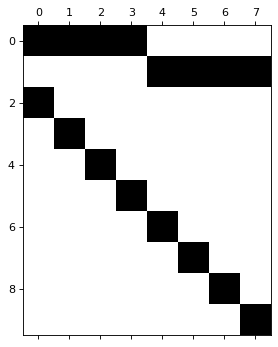

In [ ]:
hplot = HierarchicalPlot(S=S_test_df_te, tags=tags_te_test, S_id_col="temporal_id")
hplot.plot_summing_matrix()